In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from tqdm.notebook import tqdm
import torchcde
from scipy.signal import find_peaks
import MulensModel as mm
import corner
from model.utils import inference, get_loglik, get_peak_pred, plot_params, simulate_lc, infer_lgfs
from matplotlib.offsetbox import AnchoredText

torch.random.manual_seed(42)
np.random.seed(42)
plt.rcParams["font.family"] = "serif"
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'

In [2]:
with h5py.File('/work/hmzhao/irregular-lc/KMT-fixrho-test.h5', mode='r') as dataset_file:
    Y = torch.tensor(dataset_file['Y'][...])
    X = torch.tensor(dataset_file['X'][...])

Y[:, 3:6] = torch.log10(Y[:, 3:6])
Y[:, -1] = torch.log10(Y[:, -1])
Y[:, 6] = Y[:, 6] / 180
# Y = Y[:, 2:]
Y = Y[:, [2, 4, 5, 6, 7]]
print('Shape of Y: ', Y.shape)

X[:, :, 1] = (X[:, :, 1] - 14.5 - 2.5 * Y[:, [-1]]) / 0.2
print(f'normalized X mean: {torch.mean(X[:, :, 1])}\nX std: {torch.mean(torch.std(X[:, :, 1], axis=0))}')

X = X[:, :, :2]
    
# CDE interpolation with log_sig
depth = 3; window_length = 5
logsig = torchcde.logsig_windows(X, depth, window_length=window_length)
coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(logsig)

Shape of Y:  torch.Size([100000, 5])
normalized X mean: -1.1743464469848672
X std: 1.046597228312195


In [3]:
from model.cde_mdn import CDE_MDN

device = torch.device("cuda:9" if torch.cuda.is_available() else "cpu")

checkpt = torch.load('/work/hmzhao/experiments/cde_mdn/experiment_l32nG12diag.ckpt', map_location='cpu')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

output_dim = Y.shape[-1]
input_dim = logsig.shape[-1]
latent_dim = ckpt_args.latents

model = CDE_MDN(input_dim, latent_dim, output_dim).to(device)
# model = CDE_MDN(input_dim, latent_dim, output_dim, 32).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

CDE_MDN(
  (cde_func): CDEFunc(
    (linear1): Linear(in_features=32, out_features=1024, bias=True)
    (relu1): PReLU(num_parameters=1)
    (resblocks): Sequential(
      (0): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (1): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (2): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
    )
    (relu2): PReLU(num_parameters=1)
    (linear2): Linear(in_features=1024, out_features=160, bias=True)
    (tanh): Tanh()
    (linear3): Linear(in_features=

In [4]:
size = 4096 * 4

In [5]:
pis, locs, scales = inference(model, size, min(4096, size), coeffs, device, full_cov=False)

  0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
X_gap = torch.tensor(np.load('/work/hmzhao/X_gap.npy'))

In [7]:
# CDE interpolation with log_sig
depth = 3; window_length = max(X_gap.shape[1]//100, 1)
logsig = torchcde.logsig_windows(X_gap, depth, window_length=window_length)
coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(logsig)

In [8]:
pis_gap, locs_gap, scales_gap = inference(model, size, 4096, coeffs, device, full_cov=False)

  0%|          | 0/4 [00:00<?, ?it/s]

In [9]:
pred_gap = get_peak_pred(pis_gap, locs_gap, scales_gap, Y)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

In [58]:
def plot_lc(i, X, X_gap, Y, pred_gap):
    fig = plt.figure(1, (16, 8))
    plt.subplot2grid(shape=(2, 3), loc=(0, 0), rowspan=1, colspan=3)
    plt.xlabel(r'$(t - t_0)/t_E$', fontsize=14)
    plt.ylabel(r'm - m_base', fontsize=14)
    plt.xlim(-2, 2)
    gap_times = np.setdiff1d(np.floor(X[i, :, 0]*1e3), np.floor(X_gap[i, :, 0]*1e3))/1e3
    plt.axvspan(gap_times.min(), gap_times.max(), color='grey', alpha=0.2)
    plt.scatter(X_gap[i, :, 0], X_gap[i, :, 1]*0.2, color='black', marker='o', rasterized=True)
    param_true = Y[i].tolist()
    param_true.insert(1, -3)
    param_pred_gap = pred_gap[2][i].tolist()
    param_pred_gap.insert(1, -3)
    param_pred_gap_g = pred_gap[0][i].tolist()
    param_pred_gap_g.insert(1, -3)
    lc_true = simulate_lc(0, 1, *param_true, orig=True)
    lc_pred_gap = simulate_lc(0, 1, *param_pred_gap, orig=True)
    lc_pred_gap_g = simulate_lc(0, 1, *param_pred_gap_g, orig=True)
    plt.plot(lc_true[:, 0], lc_true[:, 1], color='black', linestyle='dashed', label='truth')
    plt.plot(lc_pred_gap[:, 0], lc_pred_gap[:, 1], color='red', label='close')
    plt.plot(lc_pred_gap_g[:, 0], lc_pred_gap_g[:, 1], color='orange', label='global')
    # print('parameters: u0, lgrho, lgq, lgs, alpha, lgfs')
    # print('ground truth: ', Y[i].numpy())
    # print('pred gap close: ', pred_gap[2][i].numpy())
    # print('pred gap global: ', pred_gap[0][i].numpy())
    # print(i)
    plt.gca().invert_yaxis()
    plt.legend()

    plt.subplot2grid(shape=(2, 3), loc=(1, 0), rowspan=1, colspan=1)
    param_list = [Y[i].tolist(), pred_gap[2][i].tolist(), pred_gap[0][i].tolist()]
    traj_color = ['black', 'red', 'orange']
    cau_color = ['black', 'red', 'orange']
    plt.xlabel('geometry', fontsize=14)
    plt.axis('equal')
    for j, params in enumerate(param_list):
        u_0, lgq, lgs, alpha_180, lgfs = params
        lgrho = -3
        parameters = {
                    't_0': 0,
                    't_E': 1,
                    'u_0': u_0,
                    'rho': 10**lgrho, 
                    'q': 10**lgq, 
                    's': 10**lgs, 
                    'alpha': alpha_180*180,
                }
        modelmm = mm.Model(parameters, coords=None)
        if j == 0:
            modelmm.plot_trajectory(t_range=(-2, 2), caustics=False, arrow=False, color=traj_color[j], linestyle='dashed')
        else:
            modelmm.plot_trajectory(t_range=(-2, 2), caustics=False, arrow=False, color=traj_color[j])
        modelmm.plot_caustics(color=cau_color[j], s=1)
    
    plt.subplot2grid(shape=(2, 3), loc=(1, 1), rowspan=1, colspan=2)
    label_list = ['truth', 'close', 'global']
    for j, params in enumerate(param_list):
        u_0, lgq, lgs, alpha_180, lgfs = params
        lgrho = -3
        parameters = {
                    'type': label_list[j],
                    't_0': 0,
                    't_E': 1,
                    'u_0': u_0,
                    'rho': 10**lgrho, 
                    'q': 10**lgq, 
                    's': 10**lgs, 
                    'alpha': alpha_180*180,
                }
        for k, (key, value) in enumerate(parameters.items()):
            if k==0:
                plt.text(0.05+j/3, 0.8-k/10, str(value), fontsize=14, color=traj_color[j])
            else:
                plt.text(0.05+j/3, 0.8-k/10, key+': '+'%.4f'%value, fontsize=14, color=traj_color[j])
    plt.savefig(f'/work/hmzhao/lc_examples/lc{i}.jpg')
    # plt.show()

In [59]:
mse = torch.mean((pred_gap[2] - Y[:size])**2, dim=-1)

In [60]:
sortind = torch.sort(mse)[1]

  0%|          | 0/500 [00:00<?, ?it/s]

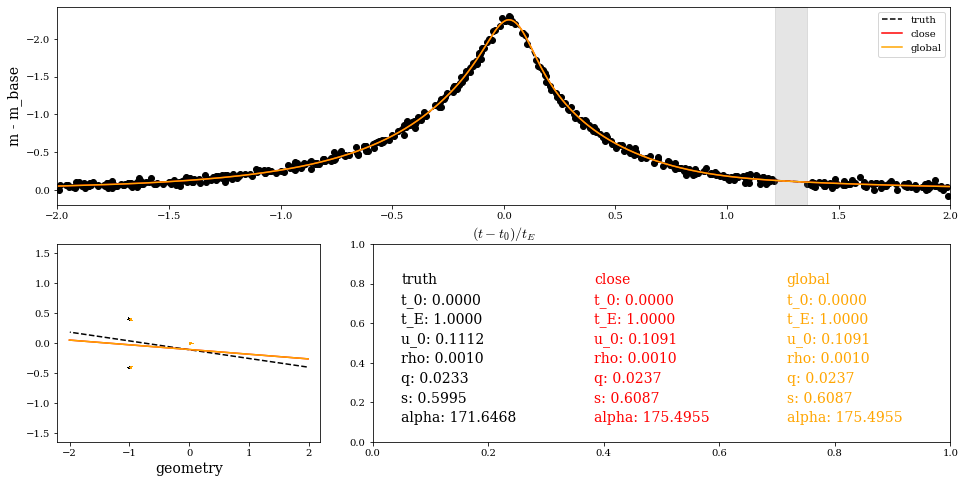

In [61]:
for i in tqdm(range(500)):
    plot_lc(sortind[i], X, X_gap, Y, pred_gap)